## **Домашнее задание.**
Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
Опишите какой результат вы получили? Что помогло вам улучшить ее точность?

In [ ]:
import pandas as pd

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

In [ ]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [ ]:
X = df_train.drop('label', axis = 1)
y = df_train['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=13)

In [ ]:
!pip install stop_words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [ ]:
from nltk.probability import FreqDist
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize

In [ ]:
import numpy as np

In [ ]:
max_words = 2000
max_len = 10
num_classes = 1

# Training
epochs = 5
batch_size = 512
print_batch_n = 100

In [ ]:
sw = set(get_stop_words("english"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

In [ ]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("not\s", "not", txt)
    txt = re.sub("no\s", "no", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [ ]:
tqdm.pandas()
X_train['tweet'] = X_train['tweet'].apply(preprocess_text)
X_val['tweet'] = X_val['tweet'].apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_text)

In [ ]:
train_corpus = " ".join(X_train["tweet"])
train_corpus = train_corpus.lower()

In [ ]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [ ]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
len(tokens_filtered_top)

1999

In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:

def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [ ]:
X_train = np.asarray([text_to_sequence(text, max_len) for text in X_train["tweet"]], dtype=np.int32)
X_val = np.asarray([text_to_sequence(text, max_len) for text in X_val["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]], dtype=np.int32)

In [ ]:
X_train.shape

(28765, 10)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(p=0.25)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = self.dropout(output)
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)
        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output


In [ ]:
class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
train_dataset = DataWrapper(X_train, y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(X_val, y_val.values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [ ]:
model = Net(vocab_size=max_words)
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [ ]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
#model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    model.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1]
        test_outputs = model(data[0])

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

    model.train()

print('Training is finished!')

Epoch [1/5]. Step [57/57]. Loss: 0.283. Acc: 0.936. Test loss: 0.060. Test acc: 0.948
Epoch [2/5]. Step [57/57]. Loss: 0.144. Acc: 0.951. Test loss: 0.803. Test acc: 0.947
Epoch [3/5]. Step [57/57]. Loss: 0.187. Acc: 0.957. Test loss: 0.061. Test acc: 0.950
Epoch [4/5]. Step [57/57]. Loss: 0.095. Acc: 0.960. Test loss: 0.018. Test acc: 0.947
Epoch [5/5]. Step [57/57]. Loss: 0.060. Acc: 0.964. Test loss: 0.033. Test acc: 0.951
Training is finished!


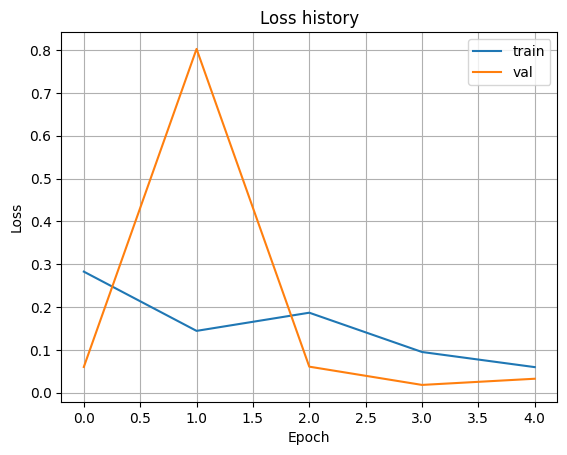

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='val')
plt.legend();

Модель показала хорошие результаты на данном датасете Test acc: 0.951.
Последовательность сделала равной 10. В модель добавила 2 слоя Dropout.